In [15]:
!pip install pyod
!pip install prince
!pip install yellowbrick
!pip install lightgbm
!pip install nbformat
!pip install sentence-transformers

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

import networkx as nx

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

In [17]:
df = pd.read_csv("db_ia.csv")
df.head()

,id_atendimento,data_venda,valor_venda,descricao_servico,valor_servico,nome_animal,peso_animal,nome_cliente,nome_funcionario,cpf_funcionario,data_atendimento,valor_total_atendimento
0,1,2024-07-15 00:00:00,75.9,Venda de Produtos da Loja,50.0,Bella,3.00,Carlos Pereira,Fernanda Costa,56789012345,2024-07-15 00:00:00,75.9
1,2,2024-07-20 00:00:00,70.0,Consulta Veterinária de Emergência,70.0,Gigi,0.25,Ricardo Lima,Ana Santos,45678901234,2024-07-20 00:00:00,70.0
2,3,2024-07-20 00:00:00,100.0,Diária Básica,100.0,Bella,3.00,Carlos Pereira,Ana Santos,45678901234,2024-07-20 00:00:00,100.0
3,4,2024-08-01 00:00:00,150.0,Transporte para Consultas,150.0,Dolly,2.20,Tiago Fernandes,Ana Santos,45678901234,2024-08-01 00:00:00,150.0
4,5,2024-08-05 00:00:00,40.0,Venda de Produtos da Loja,40.0,Piui,1.80,Juliana Martins,Ricardo Lima,89012345678,2024-08-05 00:00:00,40.0


In [18]:
def compile_text(x):

    text =  f"""ID: {x['id_atendimento']},
                Data da venda: {x['data_venda']},
                Valor: {x['valor_venda']},
                Exame: {x['descricao_servico']},
                Valor: {x['valor_servico']},
                Nome Animal: {x['nome_animal']},
                Peso Animal: {x['peso_animal']},
                Nome Cliente: {x['nome_cliente']}
                Nome Funcionario: {x['nome_funcionario']}
                CPF Funcionario: {x['cpf_funcionario']}
                Data Atendimento: {x['data_atendimento']}
                Valor Total: {x['valor_total_atendimento']}
            """

    return text

def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df,
                        x='comp1',
                        y='comp2',
                        z='comp3',
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df,
                        x='comp1',
                        y='comp2',
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

def random_sample(df: pd.DataFrame, num_rows: int) -> pd.DataFrame:
    """
    Returns a DataFrame with a specific number of rows randomly selected.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    num_rows (int): Number of rows to be randomly sampled.

    Returns:
    pd.DataFrame: New DataFrame with the random rows.
    """
    if num_rows > len(df):
        raise ValueError(f"The number of requested rows ({num_rows}) exceeds the number of rows in the DataFrame ({len(df)}).")

    return df.sample(n=num_rows, random_state=42)

def calculate_cosine_similarity(embeddings: list) -> np.ndarray:
    """
    Calculates the cosine similarity between each pair of embeddings.

    Parameters:
    embeddings (list): A list of n-dimensional embeddings (each embedding is a list or a numpy array).

    Returns:
    np.ndarray: A matrix where each element [i, j] represents the cosine similarity between embedding i and j.
    """
    # Convert the list of embeddings to a NumPy array (if not already)
    embeddings_array = np.array(embeddings)

    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_array)

    return similarity_matrix

def create_similarity_graph(similarity_matrix: np.ndarray, threshold: float) -> nx.Graph:
    """
    Creates an undirected graph from a similarity matrix where edges are formed
    between nodes with similarity greater than or equal to a given threshold.

    Parameters:
    similarity_matrix (np.ndarray): The matrix of cosine similarities.
    threshold (float): The minimum similarity value to create an edge.

    Returns:
    nx.Graph: An undirected graph where nodes are connected if their similarity is above the threshold.
    """
    # Create an empty undirected graph
    graph = nx.Graph()

    # Number of embeddings (nodes)
    num_nodes = similarity_matrix.shape[0]

    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))

    # Add edges based on the similarity threshold
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] >= threshold:
                graph.add_edge(i, j, weight=similarity_matrix[i, j])

    return graph

In [19]:
sentences = df.apply(lambda x: compile_text(x), axis=1).tolist()
sentences

['ID: 1,\n                Data da venda: 2024-07-15 00:00:00,\n                Valor: 75.9,\n                Exame: Venda de Produtos da Loja,\n                Valor: 50.0,\n                Nome Animal: Bella,\n                Peso Animal: 3.0,\n                Nome Cliente: Carlos Pereira\n                Nome Funcionario: Fernanda Costa\n                CPF Funcionario: 56789012345\n                Data Atendimento: 2024-07-15 00:00:00\n                Valor Total: 75.9\n            ',
 'ID: 2,\n                Data da venda: 2024-07-20 00:00:00,\n                Valor: 70.0,\n                Exame: Consulta Veterinária de Emergência,\n                Valor: 70.0,\n                Nome Animal: Gigi,\n                Peso Animal: 0.25,\n                Nome Cliente: Ricardo Lima\n                Nome Funcionario: Ana Santos\n                CPF Funcionario: 45678901234\n                Data Atendimento: 2024-07-20 00:00:00\n                Valor Total: 70.0\n            ',
 'ID: 3,\n 

In [20]:
model = SentenceTransformer("all-MiniLM-L6-v2")
output = model.encode(sentences=sentences,
         show_progress_bar=True,
         normalize_embeddings=True)

embeddings = pd.DataFrame(output)
print(embeddings)

Batches: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]

          0         1         2         3         4         5         6    \
0    0.005489 -0.048856 -0.037858  0.014066  0.013841  0.015585 -0.049165   
1    0.038507 -0.009263 -0.053772  0.034551 -0.008811  0.014618 -0.053253   
2    0.005066 -0.017566 -0.061538  0.011567 -0.014661  0.012249 -0.045111   
3   -0.005092 -0.031441 -0.025542  0.015461 -0.002132  0.010029 -0.012257   
4    0.017079 -0.041808 -0.026967  0.002105  0.025209 -0.000643 -0.038155   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.002182 -0.017009 -0.004530 -0.003449 -0.047905  0.014976 -0.026854   
496  0.016284 -0.036959 -0.013739  0.015098 -0.003325  0.017938 -0.035152   
497  0.003356 -0.042475 -0.003124 -0.012137 -0.031528  0.016747  0.009653   
498  0.012900 -0.046066 -0.010647  0.007843 -0.037222  0.033102 -0.023272   
499  0.013925 -0.011860 -0.008590  0.019397 -0.027205  0.005830 -0.033562   

          7         8         9    ...       374       375       376  \
0  

In [21]:
sim_matrix = calculate_cosine_similarity(embeddings)
print(sim_matrix)
print(sim_matrix.shape)

[[1.0000002  0.88090885 0.9363637  ... 0.87093735 0.9071468  0.87635744]
 [0.88090885 0.9999999  0.8925929  ... 0.83101654 0.8608304  0.84144247]
 [0.9363637  0.8925929  1.0000002  ... 0.8474288  0.8671495  0.8298693 ]
 ...
 [0.87093735 0.83101654 0.8474288  ... 1.0000002  0.9227195  0.89717245]
 [0.9071468  0.8608304  0.8671495  ... 0.9227195  1.         0.90793276]
 [0.87635744 0.84144247 0.8298693  ... 0.89717245 0.90793276 1.        ]]
(500, 500)


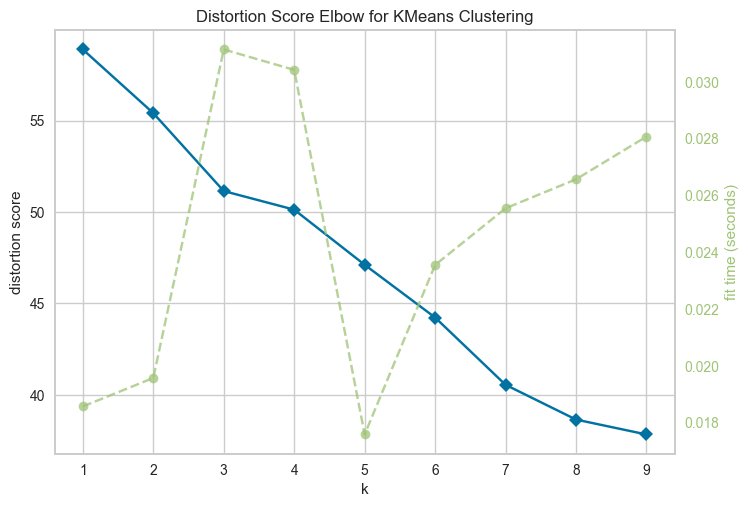

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(1,10), locate_elbow=False)

visualizer.fit(embeddings)
visualizer.show()

In [23]:
from yellowbrick.cluster import SilhouetteVisualizer

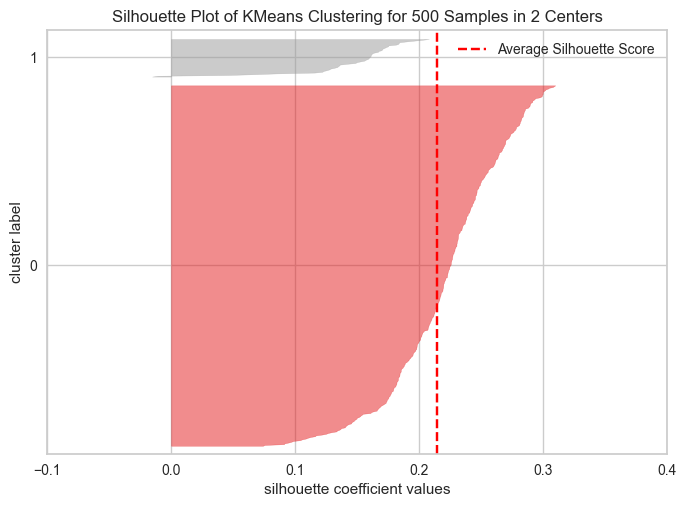

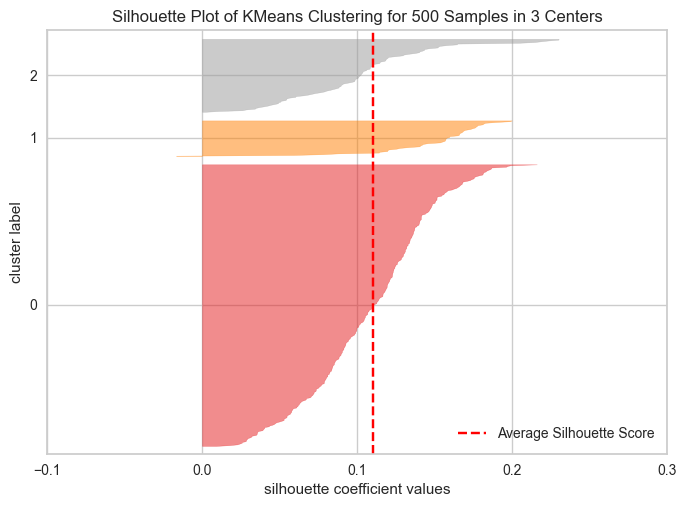

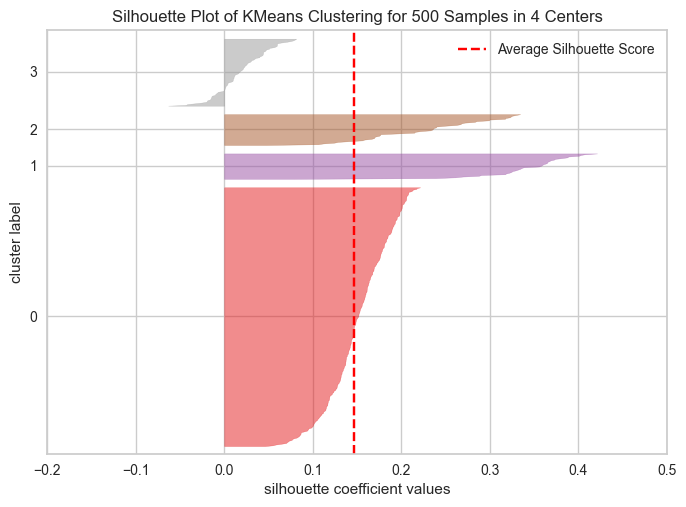

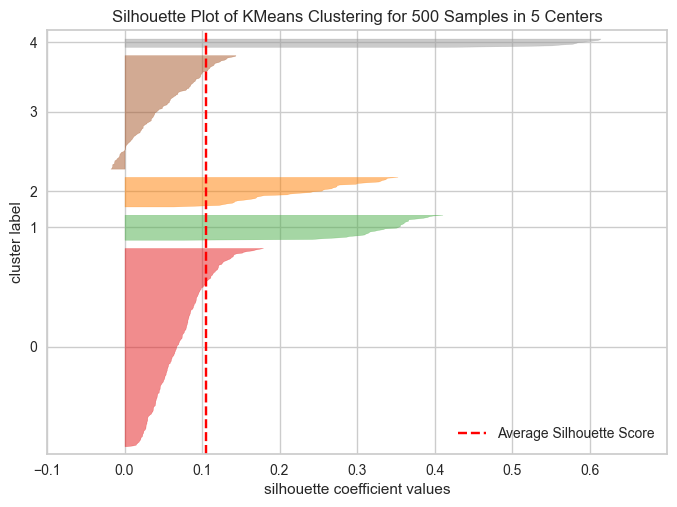

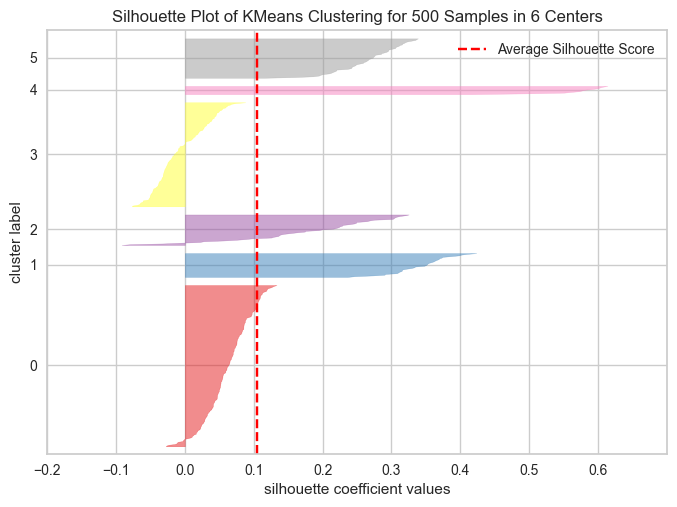

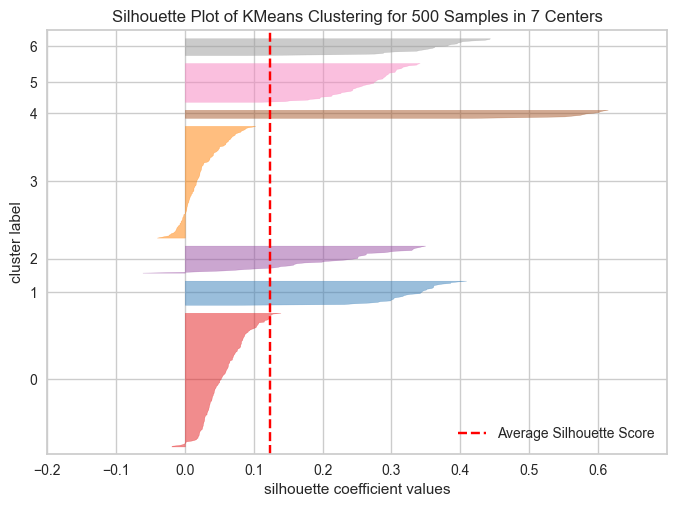

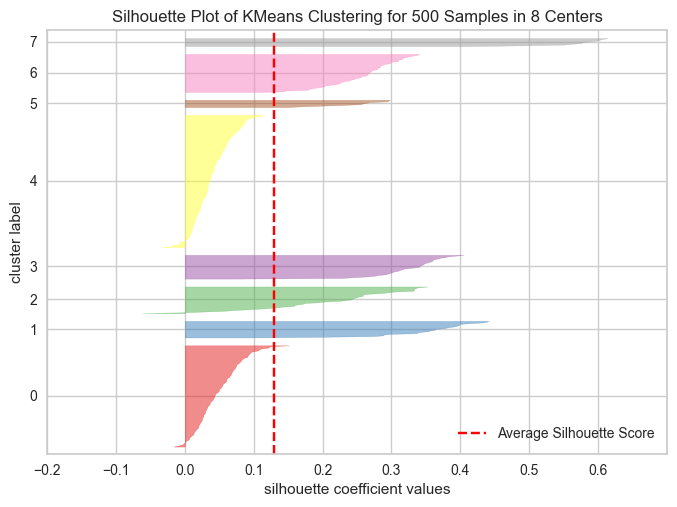

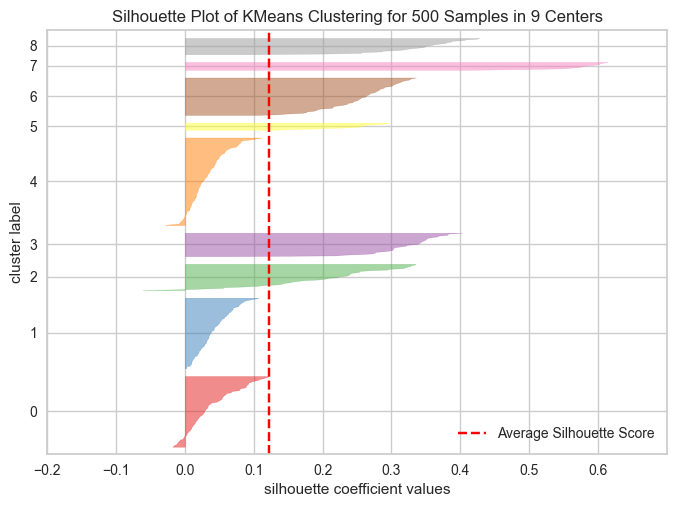

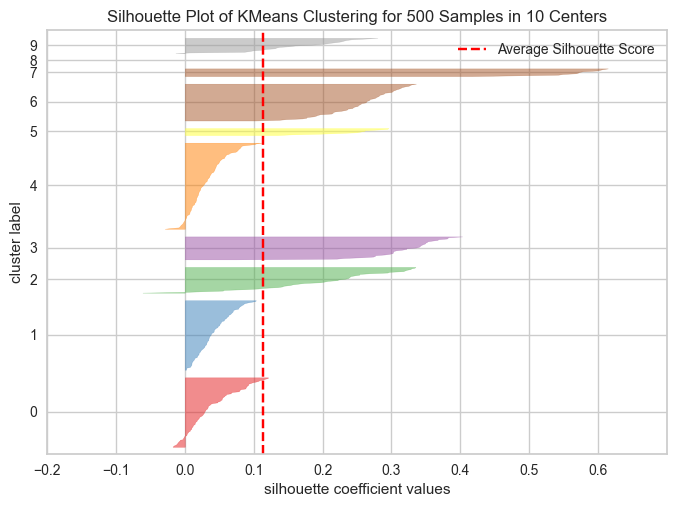

In [24]:
range_clusters = range(2, 11)
visualizers = []

for n_clusters in range_clusters:
    model = KMeans(n_clusters=n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(embeddings)
    visualizers.append(visualizer)
    visualizer.show()

In [25]:
n_clusters = 4

In [26]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(embeddings)
clusters_predict = clusters.predict(embeddings)

In [29]:
pca_3d_object, df_pca_3d = get_pca_3d(embeddings, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(embeddings, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.1)

In [ ]:
df['cluster'] = clusters.labels_
df.head()

,id_atendimento,data_venda,valor_venda,descricao_servico,valor_servico,nome_animal,peso_animal,nome_cliente,nome_funcionario,cpf_funcionario,data_atendimento,valor_total_atendimento,cluster
0,1,2024-07-15 00:00:00,75.9,Venda de Produtos da Loja,50.0,Bella,3.00,Carlos Pereira,Fernanda Costa,56789012345,2024-07-15 00:00:00,75.9,3
1,2,2024-07-20 00:00:00,70.0,Consulta Veterinária de Emergência,70.0,Gigi,0.25,Ricardo Lima,Ana Santos,45678901234,2024-07-20 00:00:00,70.0,3
2,3,2024-07-20 00:00:00,100.0,Diária Básica,100.0,Bella,3.00,Carlos Pereira,Ana Santos,45678901234,2024-07-20 00:00:00,100.0,3
3,4,2024-08-01 00:00:00,150.0,Transporte para Consultas,150.0,Dolly,2.20,Tiago Fernandes,Ana Santos,45678901234,2024-08-01 00:00:00,150.0,3
4,5,2024-08-05 00:00:00,40.0,Venda de Produtos da Loja,40.0,Piui,1.80,Juliana Martins,Ricardo Lima,89012345678,2024-08-05 00:00:00,40.0,3


In [ ]:
from google.colab import userdata

In [ ]:
!pip install -q -U google-generativeai
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [ ]:
import google.generativeai as genai

In [ ]:
Gemini_Key=userdata.get('GEMINI_AI_KEY_GENAI')

genai.configure(api_key=Gemini_Key)

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash')

In [ ]:
dados_json = df.to_json()
dados_json

'{"id_atendimento":{"0":1,"1":2,"2":3,"3":4,"4":5,"5":6,"6":7,"7":8,"8":9,"9":10,"10":11,"11":12,"12":13,"13":14,"14":15,"15":16,"16":17,"17":18,"18":19,"19":20,"20":21,"21":22,"22":23,"23":24,"24":25,"25":26,"26":27,"27":28,"28":29,"29":30,"30":31,"31":32,"32":33,"33":34,"34":35,"35":36,"36":37,"37":38,"38":39,"39":40,"40":41,"41":42,"42":43,"43":44,"44":45,"45":46,"46":47,"47":48,"48":49,"49":50,"50":51,"51":52,"52":53,"53":54,"54":55,"55":56,"56":57,"57":58,"58":59,"59":60,"60":61,"61":62,"62":63,"63":64,"64":65,"65":66,"66":67,"67":68,"68":69,"69":70,"70":71,"71":72,"72":73,"73":74,"74":75,"75":76,"76":77,"77":78,"78":79,"79":80,"80":81,"81":82,"82":83,"83":84,"84":85,"85":86,"86":87,"87":88,"88":89,"89":90,"90":91,"91":92,"92":93,"93":94,"94":95,"95":96,"96":97,"97":98,"98":99,"99":100,"100":101,"101":102,"102":103,"103":104,"104":105,"105":106,"106":107,"107":108,"108":109,"109":110,"110":111,"111":112,"112":113,"113":114,"114":115,"115":116,"116":117,"117":118,"118":119,"119":12

In [ ]:
contexto = f"""Estava analisando dados de um dataset com o obejtivo de identificar padrões úteis nos atendimentos de um petshop. Com isto em vista, gerei clusters para analisa-los.
                as colunas deste dataset são:
                -id_atendimento: id do atendimento, apenas para níveis de organiuzação;
                -data_venda: Data da venda, no caso do atendimento envolver venda de um produto;
                -valor_venda: Valor da venda, no caso do atendimento envolver venda de um produto;
                -descricao_servico: Serviço oferecido;
                -valor_servico: Valor do serviço oferecido;
                -nome_animal: Nome do animal;
                -peso_animal: Peso do animal;
                -nome_cliente: Nome do cliente, dono do animal atendido;
                -nome_funcionario: Nome do funcionário que atendeu o cliente;
                -cpf_funcionario: CPF do funcionário que atendeu o cliente;
                -data_atendimento: Data do atendimento;
                -valor_total_atendimento: Valor total do atendimento;
                -cluster: Cluster da tupla na sua totalidade;

                Note que seu objetivo é identificar qual ou quais colunas são mais determinantes para o rótulo do cluster, quero entender qual critério o algoritmo aderiu
                ao gerar os clusters. Ao identificar as colunas principais, se for o caso, diga a que faixa cada cluster se enquadra.
                Aqui estão os dados na forma de JSON:
                {dados_json}
                """
contexto

'Estava analisando dados de um dataset com o obejtivo de identificar padrões úteis nos atendimentos de um petshop. Com isto em vista, gerei clusters para analisa-los.\n                as colunas deste dataset são:\n                -id_atendimento: id do atendimento, apenas para níveis de organiuzação;\n                -data_venda: Data da venda, no caso do atendimento envolver venda de um produto;\n                -valor_venda: Valor da venda, no caso do atendimento envolver venda de um produto;\n                -descricao_servico: Serviço oferecido;\n                -valor_servico: Valor do serviço oferecido;\n                -nome_animal: Nome do animal;\n                -peso_animal: Peso do animal;\n                -nome_cliente: Nome do cliente, dono do animal atendido;\n                -nome_funcionario: Nome do funcionário que atendeu o cliente;\n                -cpf_funcionario: CPF do funcionário que atendeu o cliente;\n                -data_atendimento: Data do atendimento;\n

In [ ]:
intrucoes = """Use os dados fornecidos e obedeça o prompt do usuário, gere inferencias e use métricas como desvio padrão e correlação, trate os dados se necessário"""

In [ ]:
user_prompt = """Com base no contexto fornecido e seguindo as instruções dadas, descubra o critério adotado pelo algoritmo k-means para gerar clusters dos meus dados."""

In [ ]:
from IPython.display import display, Markdown

In [ ]:
response = model.generate_content(f"{user_prompt} \n Intrucões:{intrucoes} \n Contexto:{contexto}")
display(Markdown(response.text))

A análise dos dados revela que o algoritmo k-means provavelmente utilizou uma combinação de `valor_total_atendimento` e `descricao_servico` como critérios principais para a formação dos clusters.  A variável `valor_total_atendimento` é quantitativa e diretamente influencia a distância euclidiana usada no k-means, enquanto a `descricao_servico`, embora categórica, indiretamente influencia por meio da codificação implícita feita pelo algoritmo (provavelmente one-hot encoding ou similar, internamente).

**Inferências e Justificativas:**

1. **`valor_total_atendimento`:**  A influência desta variável é óbvia. O k-means busca minimizar a variância intra-cluster, ou seja, agrupa pontos próximos em termos de distância euclidiana.  Dados com valores totais de atendimento similares tenderão a ser agrupados no mesmo cluster.

2. **`descricao_servico`:**  A variável categórica "descricao_servico" representa diferentes tipos de serviços oferecidos.  Se o petshop oferece serviços com preços e durações significativamente diferentes,  o k-means provavelmente criou clusters que refletem a natureza desses serviços. Por exemplo, serviços de banho e tosa provavelmente formariam um cluster diferente de consultas veterinárias de emergência, dado o custo e o tempo envolvidos.


**Métricas e tratamento de dados:**

Para confirmar essas inferências, seria necessário um tratamento mais aprofundado dos dados, incluindo:

* **Codificação da variável `descricao_servico`:** Para calcular métricas quantitativas, é preciso transformar a variável categórica `descricao_servico`.  Uma abordagem seria utilizar one-hot encoding, criando novas colunas binárias para cada serviço. Após essa codificação, poderíamos calcular a correlação entre cada nova coluna binária e a variável `cluster`.  Uma alta correlação positiva indicaria que um dado serviço está fortemente associado a um determinado cluster.

* **Análise de variância (ANOVA):**  Após a codificação, a ANOVA poderia verificar se a média do `valor_total_atendimento` difere significativamente entre os clusters, fornecendo uma medida de separação entre os grupos.

* **Visualização:** Criar gráficos de dispersão com `valor_total_atendimento` no eixo x e as variáveis codificadas de `descricao_servico` nos eixos y (um gráfico para cada serviço), mostrando a distribuição dos clusters. Isso permitiria uma inspeção visual da relação entre as variáveis e a formação dos clusters.

**Faixas dos Clusters (Hipotética, sem análise estatística completa):**

Sem a análise estatística completa (mencionada acima), posso apenas especular sobre as faixas de cada cluster. A suposição abaixo é baseada em  lógica intuitiva da natureza dos serviços e do preço total:


* **Cluster 1 (serviços de alta complexidade/custo):** Consultas veterinárias de emergência, cirurgias, internações (se existirem no dataset). `Valor_total_atendimento` alto.

* **Cluster 2 (serviços diversos e custos intermediários):**  Uma mistura de serviços, como consultas gerais, exames (sangue, parasitológicos), aplicação de vacinas, etc. `Valor_total_atendimento` intermediário.

* **Cluster 3 (serviços de menor custo/simples):**  Banhos, tosas higiênicas, aparação de unhas e venda de produtos. `Valor_total_atendimento` baixo.


* **Cluster 0 (diárias):** Diárias básicas ou com recreação.  O `valor_total_atendimento` pode variar de acordo com a duração, porém seria um grupo separado devido à natureza do serviço.


**Conclusão:**

É crucial realizar as análises estatísticas (codificação, ANOVA e visualização) descritas acima para obter uma conclusão precisa e baseada em dados sobre os critérios de agrupamento utilizados pelo k-means. A análise superficial indica que `valor_total_atendimento` e `descricao_servico` são os principais determinantes, mas essa conclusão precisa de validação estatística.
